# **1. Importación de *modules***

In [1]:
import numpy as np
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# **2. Importación del dataset *properatti.csv***

In [2]:
data_raw = pd.read_csv("../data/properatti.csv", sep = ",", low_memory=False) 
#data.head(3)
data_raw.shape

(121220, 26)

# **3. Tratamiento de los datos**

## **3.1. Selección del subdataset AMBA**

In [3]:
amba = ['Capital Federal', 'Bs.As. G.B.A. Zona Sur', 'Bs.As. G.B.A. Zona Norte', 'Bs.As. G.B.A. Zona Oeste']
data_amba = data_raw[data_raw["state_name"].isin(amba)]
data_amba.shape

(81150, 26)

## **3.2. Limpieza e imputaciones**

### 3.2.1. Dropeo de columnas no informativas

In [4]:
cols2keep = ['property_type', 'state_name', 'place_name','place_with_parent_names','surface_total_in_m2','surface_covered_in_m2','price_usd_per_m2', 'rooms', 'description', 'title', 'properati_url']
data_col_clean = data_amba.loc[:, cols2keep]
data_col_clean.columns
data_col_clean.shape

Index(['property_type', 'state_name', 'place_name', 'place_with_parent_names',
       'surface_total_in_m2', 'surface_covered_in_m2', 'price_usd_per_m2',
       'rooms', 'description', 'title', 'properati_url'],
      dtype='object')

(81150, 11)

### 3.2.2. Chequeo de valores nulos (no modifica datasets)

In [5]:
cant_nulos_por_campo = data_col_clean.apply(lambda x: x.isnull().sum(), axis = 0)
percent_nulos_por_campo = data_col_clean.apply(lambda x: (100 * x.isnull().sum() / data_col_clean.shape[0]).round(2), axis = 0)
pd.DataFrame({'null': cant_nulos_por_campo, '%': percent_nulos_por_campo,'type': data_col_clean.dtypes})

,null,%,type
property_type,0,0.00,object
state_name,0,0.00,object
place_name,23,0.03,object
place_with_parent_names,0,0.00,object
surface_total_in_m2,22792,28.09,float64
surface_covered_in_m2,8505,10.48,float64
price_usd_per_m2,29515,36.37,float64
rooms,51211,63.11,float64
description,1,0.00,object
title,0,0.00,object


### 3.2.3. Imputación de la columna *rooms*


In [6]:
# Comprobamos el tipo y los valores (no modifica datasets)
print(f'''summary rooms

type: {data_col_clean.rooms.dtype}
N total: {data_col_clean.shape[0]}
N null: {data_col_clean.rooms.isnull().sum()}
% null: {round((data_col_clean.rooms.isnull().sum() / data_col_clean.shape[0] * 100), 2)}%
unique: {np.sort(data_col_clean['rooms'].unique())}''')

summary rooms

type: float64
N total: 81150
N null: 51211
% null: 63.11%
unique: [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 22. 25. 32. nan]


In [7]:
# Uniformamos la capitalización de las variables que se van a usar para imputar rooms
data_col_clean['title'] = data_col_clean.title.str.upper()
data_col_clean['description'] = data_col_clean.description.str.upper()

In [8]:
room_mapper = {"UNO": "1", "UN": "1", "DOS": "2", "TRES": "3", "CUATRO": "4", "CINCO": "5", "SEIS": "6", "SIETE": "7", "OCHO": "8",
             "NUEVE": "9", "DIEZ": "10", "MONO AMBIENTE": "1 AMBIENTE", "MONOAMBIENTE": "1 AMBIENTE", "MONOAMB" : "1 AMBIENTE", "AMBIENTE DIVISIBLE": "1 AMBIENTE",
             "DORMITORIOS": "AMBIENTE", "DORMITORIO": "AMBIENTE", "HABITACIONES": "AMBIENTE", "HABITACION": "AMBIENTE"}

for key in room_mapper.keys():
    data_col_clean.description = data_col_clean.description.str.replace(key, room_mapper[key], regex = False)
    data_col_clean.title = data_col_clean.title.str.replace(key, room_mapper[key], regex = False)

In [9]:
data_input = data_col_clean

array_regex = ["(\d+)AMB", "(\d+) AMB"]

for regex in array_regex:
    controlRooms = data_input[(data_input.rooms.isnull())]
    controlRooms.rooms = controlRooms.title.str.extract(regex).astype(float)
    data_input.update(controlRooms)
    controlRooms = data_input[(data_input.rooms.isnull())]
    controlRooms.rooms = controlRooms.description.str.extract(regex).astype(float)
    data_input.update(controlRooms)

array_regex = ["(\d+)DORM", "(\d+) DORM", "(\d+)HABITACIO", "(\d+) HABITACIO"]

for regex in array_regex:
    controlRooms = data_input[(data_input.rooms.isnull())]
    controlRooms.rooms = controlRooms.title.str.extract(regex).astype(float) - 1
    data_input.update(controlRooms)
    controlRooms = data_input[(data_input.rooms.isnull())]
    controlRooms.rooms = controlRooms.description.str.extract(regex).astype(float) - 1
    data_input.update(controlRooms)

/mnt/Data/ProgramFiles/anaconda3/envs/dhds22/lib/python3.8/site-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [10]:
# Comprobamos el tipo y los valores luego de la imputación (no modifica datasets)
print(f'''summary rooms

type: {data_input['rooms'].dtype}
N total: {data_input.shape[0]}
N null: {data_input['rooms'].isnull().sum()}
% null: {round((data_input['rooms'].isnull().sum() / data_col_clean.shape[0] * 100), 2)}%
unique: {np.sort(data_input['rooms'].unique())}''')

summary rooms

type: float64
N total: 81150
N null: 10685
% null: 13.17%
unique: [0.0000e+00 1.0000e+00 2.0000e+00 3.0000e+00 4.0000e+00 5.0000e+00
 6.0000e+00 7.0000e+00 8.0000e+00 9.0000e+00 1.0000e+01 1.1000e+01
 1.2000e+01 1.3000e+01 1.4000e+01 1.5000e+01 1.6000e+01 1.7000e+01
 1.8000e+01 2.0000e+01 2.1000e+01 2.2000e+01 2.3000e+01 2.4000e+01
 2.5000e+01 2.7000e+01 2.9000e+01 3.0000e+01 3.2000e+01 3.3000e+01
 3.5000e+01 3.6000e+01 3.7000e+01 4.0000e+01 4.2000e+01 4.5000e+01
 4.7000e+01 5.0000e+01 5.1000e+01 5.2000e+01 5.4000e+01 6.0000e+01
 6.2000e+01 7.0000e+01 7.2000e+01 8.0000e+01 8.2000e+01 8.3000e+01
 8.5000e+01 8.7000e+01 9.0000e+01 9.1000e+01 1.0000e+02 1.0300e+02
 1.2500e+02 2.1000e+02 2.7200e+02 4.0300e+02 6.0200e+02 6.6200e+02
 7.7200e+02 8.3100e+02 9.0200e+02 2.0000e+03 4.0000e+03 6.0030e+03
 2.0173e+04 2.0174e+04 6.5003e+04 1.1200e+05        nan]


### 3.2.4. Dropeo de duplicados

In [11]:
data_input.drop_duplicates(keep = "first", inplace = True)

### 3.2.5. Limpieza de *outliers* en *price_usd_per_m2*

In [12]:
#búsqueda y reemplazo de outliers (de más de 2 std, 95%) por NaN en las columnas numéricas, en un solo paso
data_out = data_input
df_sub = data_out.loc[:, 'price_usd_per_m2']
lim = np.abs((df_sub - df_sub.mean()) / df_sub.std(ddof=0)) < 2
data_out.loc[:, 'price_usd_per_m2'] = df_sub.where(lim, np.nan)
data_out.shape

(81150, 11)

### 3.2.6. Limpieza de *outliers* en *rooms*, *surface_covered* y *surface_total*

In [13]:
data_out = data_out.loc[(data_out['rooms'] <= 10) & (data_out['surface_covered_in_m2'] <= 700) & (data_out['surface_total_in_m2'] <= 1000)]
data_out.shape

(47174, 11)

### 3.2.7. Dropeo de *NaNs*

In [14]:
data_na = data_out
data_na.dropna(axis = 0, how = 'any', subset = ['property_type', 'state_name', 'place_name', 'surface_total_in_m2','surface_covered_in_m2', 'rooms', 'price_usd_per_m2'], inplace = True)
data_na.shape

/tmp/ipykernel_22212/51777832.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_na.dropna(axis = 0, how = 'any', subset = ['property_type', 'state_name', 'place_name', 'surface_total_in_m2','surface_covered_in_m2', 'rooms', 'price_usd_per_m2'], inplace = True)


(41760, 11)

In [15]:
# Último chequeo de que no hay nans en las columnas de trabajo (feature y targets)

cant_nulos_por_campo = data_na.apply(lambda x: x.isnull().sum(), axis = 0)
percent_nulos_por_campo = data_na.apply(lambda x: (100 * x.isnull().sum() / data_na.shape[0]).round(2), axis = 0)
pd.DataFrame({'null': cant_nulos_por_campo, '%': percent_nulos_por_campo,'type': data_na.dtypes})

,null,%,type
property_type,0,0.0,object
state_name,0,0.0,object
place_name,0,0.0,object
place_with_parent_names,0,0.0,object
surface_total_in_m2,0,0.0,float64
surface_covered_in_m2,0,0.0,float64
price_usd_per_m2,0,0.0,float64
rooms,0,0.0,float64
description,0,0.0,object
title,0,0.0,object


### 3.2.8. Ploteo de correlación entre variables

<AxesSubplot:>

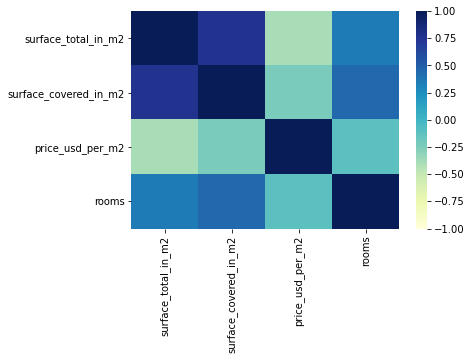

In [16]:
sns.heatmap(data_na.corr(), vmin=-1, vmax=1, center=0, cmap="YlGnBu")

## **3.3. Creacion de columnas *dummies***

### 3.3.1. *Amenities*

In [17]:
#fracciono la columna properti_url para sacar la nube de palabras mas repetidas
patron_url = re.compile(pattern = "_", flags = re.IGNORECASE)
lista_url = data_na["properati_url"].apply(lambda x : patron_url.split(x))
serie_palabras = pd.Series(np.hstack(lista_url))
#serie_palabras.value_counts().head(20).plot(kind="bar")
serie_palabras.value_counts().head(50)

venta                       41707
departamento                27273
garage                      21321
lavadero                    19150
balcon                      17077
parrilla                    15963
luminoso                    13776
piscina                     13440
suite                       12475
casa                        11905
toilette                    11485
placard                     10813
terraza                     10564
vestidor                     8436
jardin                       7475
patio                        6466
dependencias                 6031
sum                          5935
aire-acondicionado           5553
baulera                      5432
amenities                    5415
gimnasio                     4698
estrenar                     4368
lujoso                       4235
vista                        3670
subte-linea-d                3620
quincho                      3286
hidromasaje                  2981
subte-linea-b                2975
subte-linea-a 

In [18]:
# a partir de la nube de palabras selecciono las que son buenos adicionales
adicionales = ["garage", "balcon", "parrilla", "piscina", "terraza", "patio", "jardin", "quincho", "sum", "amenities", "baulera", "gimnasio", "subte-linea-d", "subte-linea-b", "subte-linea-a", "subte-linea-h", "subte-linea-e"]

In [19]:
#elimino el primer elemento de lista_url para no tener el elemento con el http: etc
for sublist in lista_url:
  del sublist[0]

lista_url

0         [venta, ph, mataderos, lavadero, patio, inmobi...
2         [venta, departamentos, mataderos, lavadero, pl...
6         [venta, ph, munro, lavadero, patio, garage, al...
7         [venta, departamentos, belgrano, lavadero, pis...
8         [venta, departamentos, belgrano, lavadero, pis...
                                ...                        
121154    [venta, casa, la-plata, suite, parrilla, pisci...
121158    [venta, departamento, recoleta, pueyrredon-av-...
121215    [venta, departamento, belgrano, balcon, suite,...
121216    [venta, casa, beccar, suite, hidromasaje, jard...
121217    [venta, departamento, villa-urquiza, holmberg,...
Name: properati_url, Length: 41760, dtype: object

In [20]:
#creo una función que compare la lista de palabras con la lista de listas
#y me da como resultado una lista de listas de palabras true/false segun coincida o no 
def buscador_palabras(quebuscar, dondebuscar):
  listadeextras = []
  for listas in dondebuscar:
    extras = []
    for palabra in quebuscar:
      if palabra in listas:
        extras.append(1)
      else:
        extras.append(0)
    listadeextras.append(extras)
  #print(listadeextras)
  return listadeextras     

In [21]:
#aplico la funcion a mi lista "adicionales" y "lista_url"
#chequeo que tenga la misma longitud de data
resultado = buscador_palabras(adicionales, lista_url)
len(resultado)

41760

In [22]:
#convierto resultado en dataframe, y renombro las columnas por la lista de palabras adicionales
df = pd.DataFrame(resultado)
df.columns = ["garage", "balcon", "parrilla", "piscina", "terraza", "patio", "jardin", "quincho", "s.u.m.", "amenities", "baulera", "gimnasio","subte-linea-d", "subte-linea-b", "subte-linea-a", "subte-linea-h", "subte-linea-e"]
df = df.add_prefix('am_')
df

,am_garage,am_balcon,am_parrilla,am_piscina,am_terraza,am_patio,am_jardin,am_quincho,am_s.u.m.,am_amenities,am_baulera,am_gimnasio,am_subte-linea-d,am_subte-linea-b,am_subte-linea-a,am_subte-linea-h,am_subte-linea-e
0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41755,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
41756,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
41757,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0
41758,1,0,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0


In [23]:
#uno el dataframe original con el nuevo generado de true/false
#data = pd.merge(data,df,left_index=True, right_index=True)
data_dum_1 = data_na.reset_index().join(df)
data_dum_1.columns
#antes me puso los dos indices como resultado del merge, y tuve que sacar la primera columna
#data.drop(columns=data.columns[0], axis=1,inplace=True)
data_dum_1.shape

Index(['index', 'property_type', 'state_name', 'place_name',
       'place_with_parent_names', 'surface_total_in_m2',
       'surface_covered_in_m2', 'price_usd_per_m2', 'rooms', 'description',
       'title', 'properati_url', 'am_garage', 'am_balcon', 'am_parrilla',
       'am_piscina', 'am_terraza', 'am_patio', 'am_jardin', 'am_quincho',
       'am_s.u.m.', 'am_amenities', 'am_baulera', 'am_gimnasio',
       'am_subte-linea-d', 'am_subte-linea-b', 'am_subte-linea-a',
       'am_subte-linea-h', 'am_subte-linea-e'],
      dtype='object')

(41760, 29)

### 3.3.2. *State name*

In [24]:
df_sn = pd.get_dummies(data_dum_1["state_name"], prefix = 'sn', drop_first = True)

In [25]:
data_dum_2 = data_dum_1.join(df_sn)
data_dum_2.columns
data_dum_2.shape

Index(['index', 'property_type', 'state_name', 'place_name',
       'place_with_parent_names', 'surface_total_in_m2',
       'surface_covered_in_m2', 'price_usd_per_m2', 'rooms', 'description',
       'title', 'properati_url', 'am_garage', 'am_balcon', 'am_parrilla',
       'am_piscina', 'am_terraza', 'am_patio', 'am_jardin', 'am_quincho',
       'am_s.u.m.', 'am_amenities', 'am_baulera', 'am_gimnasio',
       'am_subte-linea-d', 'am_subte-linea-b', 'am_subte-linea-a',
       'am_subte-linea-h', 'am_subte-linea-e', 'sn_Bs.As. G.B.A. Zona Oeste',
       'sn_Bs.As. G.B.A. Zona Sur', 'sn_Capital Federal'],
      dtype='object')

(41760, 32)

### 3.3.3. *Property type*

In [26]:
df_pt = pd.get_dummies(data_dum_2["property_type"], prefix = 'pt', drop_first = True)

In [27]:
data_dum_3 = data_dum_2.join(df_pt)
data_dum_3.columns
data_dum_3.shape

Index(['index', 'property_type', 'state_name', 'place_name',
       'place_with_parent_names', 'surface_total_in_m2',
       'surface_covered_in_m2', 'price_usd_per_m2', 'rooms', 'description',
       'title', 'properati_url', 'am_garage', 'am_balcon', 'am_parrilla',
       'am_piscina', 'am_terraza', 'am_patio', 'am_jardin', 'am_quincho',
       'am_s.u.m.', 'am_amenities', 'am_baulera', 'am_gimnasio',
       'am_subte-linea-d', 'am_subte-linea-b', 'am_subte-linea-a',
       'am_subte-linea-h', 'am_subte-linea-e', 'sn_Bs.As. G.B.A. Zona Oeste',
       'sn_Bs.As. G.B.A. Zona Sur', 'sn_Capital Federal', 'pt_apartment',
       'pt_house', 'pt_store'],
      dtype='object')

(41760, 35)

### 3.3.4. *Place name*

In [28]:
df_pn = pd.get_dummies(data_dum_3["place_name"], prefix = "pn", drop_first = True)

In [29]:
data_dum_4 = data_dum_3.join(df_pn)
data_dum_4.columns
data_dum_4.shape

Index(['index', 'property_type', 'state_name', 'place_name',
       'place_with_parent_names', 'surface_total_in_m2',
       'surface_covered_in_m2', 'price_usd_per_m2', 'rooms', 'description',
       ...
       'pn_Villa de Mayo', 'pn_Villa del Parque',
       'pn_Village Golf & Tennis Country Club', 'pn_Virasoro Village',
       'pn_Virrey del Pino', 'pn_Virreyes', 'pn_Wilde', 'pn_William Morris',
       'pn_Zelaya', 'pn_coordenadas 34.255511'],
      dtype='object', length=475)

(41760, 475)

### 3.3.5. Dropeo de columnas innecesarias

In [30]:
data = data_dum_4.drop(columns = ['index', 'property_type', 'state_name', 'place_name', 'place_with_parent_names', 'description', 'title', 'properati_url'])
bool_mapper = {False: 0, True: 1}
data.replace(bool_mapper, inplace = True)
data.shape
#list(data.columns)
data

(41760, 467)

,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,rooms,am_garage,am_balcon,am_parrilla,am_piscina,am_terraza,am_patio,...,pn_Villa de Mayo,pn_Villa del Parque,pn_Village Golf & Tennis Country Club,pn_Virasoro Village,pn_Virrey del Pino,pn_Virreyes,pn_Wilde,pn_William Morris,pn_Zelaya,pn_coordenadas 34.255511
0,55.0,40.0,1127.272727,2.0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,55.0,55.0,1309.090909,2.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,106.0,78.0,1226.415094,2.0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,45.0,40.0,3066.666667,1.0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,65.0,60.0,3000.000000,2.0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41755,205.0,205.0,1439.024390,3.0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
41756,44.0,39.0,3750.000000,1.0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41757,113.0,93.0,7699.115044,3.0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
41758,360.0,360.0,1383.333333,3.0,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
cant_nulos_por_campo = data.apply(lambda x: x.isnull().sum(), axis = 0)
percent_nulos_por_campo = data.apply(lambda x: (100 * x.isnull().sum() / data_na.shape[0]).round(2), axis = 0)
pd.DataFrame({'null': cant_nulos_por_campo, '%': percent_nulos_por_campo,'type': data.dtypes})

,null,%,type
surface_total_in_m2,0,0.0,float64
surface_covered_in_m2,0,0.0,float64
price_usd_per_m2,0,0.0,float64
rooms,0,0.0,float64
am_garage,0,0.0,int64
...,...,...,...
pn_Virreyes,0,0.0,int64
pn_Wilde,0,0.0,int64
pn_William Morris,0,0.0,int64
pn_Zelaya,0,0.0,int64


# **4. Exportación del dataset resultante a un nuevo *.csv***

In [32]:
# para exportar resultados
data.to_csv(r'../data/properatti_tp2.csv', index = False, header=True)

In [33]:
# para usar el nuevo dataset desde el archivo
# data = pd.read_csv("../data/properatti_tp2.csv", sep = ",", low_memory=False) 
# data.head(3)
# data.shape